<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/sequences-time-series-and-prediction/Sunspots.csv
100%|███████████████████████████████████████| 70.8k/70.8k [00:00<00:00, 213kB/s]


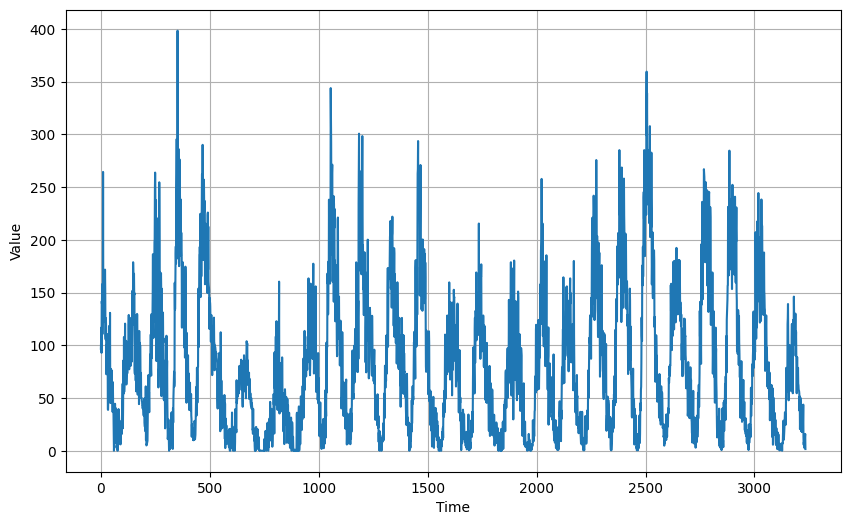

In [4]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

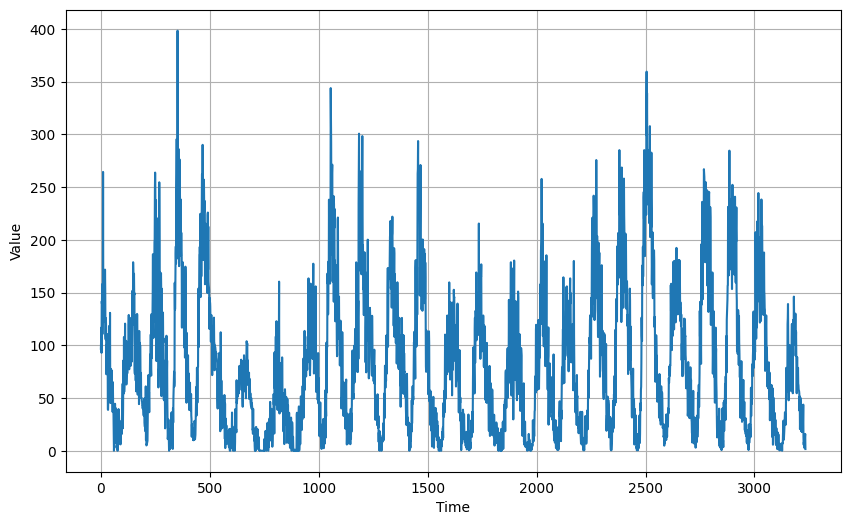

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=valid_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 182ms/step - loss: 89.7208 - mae: 90.2190 - val_loss: 89.0707 - val_mae: 89.5689 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 70ms/step - loss: 88.3086 - mae: 88.8066 - val_loss: 87.2265 - val_mae: 87.7242 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 68ms/step - loss: 86.2859 - mae: 86.7836 - val_loss: 85.0713 - val_mae: 85.5692 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 71ms/step - loss: 84.1063 - mae: 84.6041 - val_loss: 82.8932 - val_mae: 83.3909 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 67ms/step - loss: 81.9821 - mae: 82.4797 - val_loss: 80.8926 - val_mae: 81.3898 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 71ms/step - loss: 80.1163 - mae: 80.6132 - val_loss: 79.2396 - val_mae: 79.7

12/12 [==============================] - 1s 69ms/step - loss: 21.8674 - mae: 22.3613 - val_loss: 21.4319 - val_mae: 21.9260 - lr: 3.9811e-06
Epoch 54/100
12/12 [==============================] - 1s 67ms/step - loss: 21.7245 - mae: 22.2187 - val_loss: 23.4454 - val_mae: 23.9391 - lr: 4.4668e-06
Epoch 55/100
12/12 [==============================] - 1s 68ms/step - loss: 22.0560 - mae: 22.5498 - val_loss: 21.2183 - val_mae: 21.7122 - lr: 5.0119e-06
Epoch 56/100
12/12 [==============================] - 1s 67ms/step - loss: 20.8519 - mae: 21.3458 - val_loss: 20.5441 - val_mae: 21.0376 - lr: 5.6234e-06
Epoch 57/100
12/12 [==============================] - 1s 67ms/step - loss: 20.5820 - mae: 21.0751 - val_loss: 25.2229 - val_mae: 25.7167 - lr: 6.3096e-06
Epoch 58/100
12/12 [==============================] - 1s 67ms/step - loss: 21.3902 - mae: 21.8837 - val_loss: 20.1824 - val_mae: 20.6762 - lr: 7.0795e-06
Epoch 59/100
12/12 [==============================] - 1s 69ms/step - loss: 20.2680 - mae:

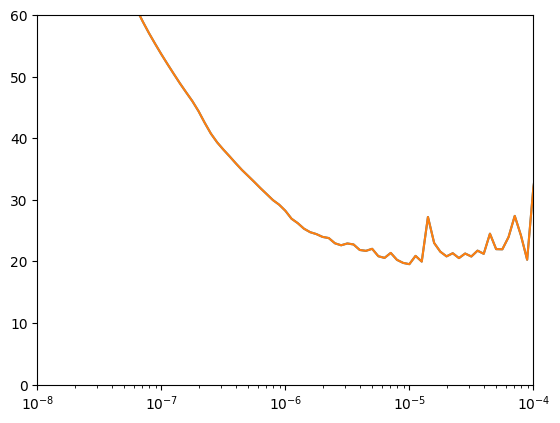

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.show()

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, validation_data=valid_set)

Epoch 1/500
30/30 [==============================] - 5s 48ms/step - loss: 35.3804 - mae: 35.8761 - val_loss: 19.4236 - val_mae: 19.9130
Epoch 2/500
30/30 [==============================] - 1s 15ms/step - loss: 23.7736 - mae: 24.2676 - val_loss: 21.5573 - val_mae: 22.0524
Epoch 3/500
30/30 [==============================] - 1s 16ms/step - loss: 22.2222 - mae: 22.7160 - val_loss: 16.0750 - val_mae: 16.5618
Epoch 4/500
30/30 [==============================] - 1s 15ms/step - loss: 21.3911 - mae: 21.8845 - val_loss: 14.4542 - val_mae: 14.9395
Epoch 5/500
30/30 [==============================] - 1s 15ms/step - loss: 20.0065 - mae: 20.4995 - val_loss: 15.8563 - val_mae: 16.3484
Epoch 6/500
30/30 [==============================] - 1s 15ms/step - loss: 19.6800 - mae: 20.1728 - val_loss: 14.0722 - val_mae: 14.5611
Epoch 7/500
30/30 [==============================] - 1s 16ms/step - loss: 19.3638 - mae: 19.8563 - val_loss: 14.3759 - val_mae: 14.8660
Epoch 8/500
30/30 [=============================

Epoch 61/500
30/30 [==============================] - 1s 15ms/step - loss: 16.7135 - mae: 17.2038 - val_loss: 13.1113 - val_mae: 13.6023
Epoch 62/500
30/30 [==============================] - 1s 15ms/step - loss: 16.8194 - mae: 17.3101 - val_loss: 13.0430 - val_mae: 13.5345
Epoch 63/500
30/30 [==============================] - 1s 16ms/step - loss: 16.5494 - mae: 17.0388 - val_loss: 12.9701 - val_mae: 13.4606
Epoch 64/500
30/30 [==============================] - 1s 15ms/step - loss: 16.5008 - mae: 16.9903 - val_loss: 13.0214 - val_mae: 13.5125
Epoch 65/500
30/30 [==============================] - 1s 15ms/step - loss: 16.5341 - mae: 17.0236 - val_loss: 12.9493 - val_mae: 13.4390
Epoch 66/500
30/30 [==============================] - 1s 15ms/step - loss: 16.5128 - mae: 17.0026 - val_loss: 12.9924 - val_mae: 13.4817
Epoch 67/500
30/30 [==============================] - 1s 15ms/step - loss: 16.5003 - mae: 16.9899 - val_loss: 13.0096 - val_mae: 13.5002
Epoch 68/500
30/30 [=====================

30/30 [==============================] - 1s 15ms/step - loss: 16.1993 - mae: 16.6887 - val_loss: 13.2426 - val_mae: 13.7338
Epoch 121/500
30/30 [==============================] - 1s 15ms/step - loss: 16.2729 - mae: 16.7629 - val_loss: 13.0308 - val_mae: 13.5233
Epoch 122/500
30/30 [==============================] - 1s 16ms/step - loss: 16.1950 - mae: 16.6845 - val_loss: 13.8986 - val_mae: 14.3896
Epoch 123/500
30/30 [==============================] - 1s 15ms/step - loss: 16.4258 - mae: 16.9161 - val_loss: 13.6714 - val_mae: 14.1632
Epoch 124/500
30/30 [==============================] - 1s 16ms/step - loss: 16.4067 - mae: 16.8966 - val_loss: 13.0663 - val_mae: 13.5572
Epoch 125/500
30/30 [==============================] - 1s 15ms/step - loss: 16.2379 - mae: 16.7275 - val_loss: 12.9864 - val_mae: 13.4762
Epoch 126/500
30/30 [==============================] - 1s 16ms/step - loss: 16.1221 - mae: 16.6115 - val_loss: 13.0839 - val_mae: 13.5770
Epoch 127/500
30/30 [===========================

30/30 [==============================] - 1s 15ms/step - loss: 15.9794 - mae: 16.4681 - val_loss: 13.2210 - val_mae: 13.7127
Epoch 180/500
30/30 [==============================] - 1s 15ms/step - loss: 16.0257 - mae: 16.5152 - val_loss: 13.2184 - val_mae: 13.7092
Epoch 181/500
30/30 [==============================] - 1s 16ms/step - loss: 15.9189 - mae: 16.4076 - val_loss: 13.1886 - val_mae: 13.6802
Epoch 182/500
30/30 [==============================] - 1s 16ms/step - loss: 15.8814 - mae: 16.3700 - val_loss: 13.1252 - val_mae: 13.6169
Epoch 183/500
30/30 [==============================] - 1s 15ms/step - loss: 15.9543 - mae: 16.4431 - val_loss: 13.3284 - val_mae: 13.8193
Epoch 184/500
30/30 [==============================] - 1s 15ms/step - loss: 15.9767 - mae: 16.4661 - val_loss: 13.0636 - val_mae: 13.5558
Epoch 185/500
30/30 [==============================] - 1s 15ms/step - loss: 15.7947 - mae: 16.2827 - val_loss: 13.2332 - val_mae: 13.7245
Epoch 186/500
30/30 [===========================

30/30 [==============================] - 1s 15ms/step - loss: 15.8010 - mae: 16.2899 - val_loss: 13.3163 - val_mae: 13.8085
Epoch 239/500
30/30 [==============================] - 1s 15ms/step - loss: 15.7217 - mae: 16.2103 - val_loss: 13.5355 - val_mae: 14.0268
Epoch 240/500
30/30 [==============================] - 1s 16ms/step - loss: 15.6072 - mae: 16.0949 - val_loss: 13.4186 - val_mae: 13.9095
Epoch 241/500
30/30 [==============================] - 1s 15ms/step - loss: 15.6028 - mae: 16.0909 - val_loss: 13.5080 - val_mae: 14.0016
Epoch 242/500
30/30 [==============================] - 1s 16ms/step - loss: 15.6845 - mae: 16.1728 - val_loss: 13.3488 - val_mae: 13.8378
Epoch 243/500
30/30 [==============================] - 1s 15ms/step - loss: 15.8153 - mae: 16.3042 - val_loss: 13.4291 - val_mae: 13.9184
Epoch 244/500
30/30 [==============================] - 1s 15ms/step - loss: 15.6837 - mae: 16.1722 - val_loss: 13.3355 - val_mae: 13.8276
Epoch 245/500
30/30 [===========================

30/30 [==============================] - 1s 17ms/step - loss: 15.5494 - mae: 16.0375 - val_loss: 13.6579 - val_mae: 14.1502
Epoch 298/500
30/30 [==============================] - 1s 16ms/step - loss: 15.4663 - mae: 15.9545 - val_loss: 13.4776 - val_mae: 13.9674
Epoch 299/500
30/30 [==============================] - 1s 17ms/step - loss: 15.3563 - mae: 15.8443 - val_loss: 13.5790 - val_mae: 14.0702
Epoch 300/500
30/30 [==============================] - 1s 17ms/step - loss: 15.3396 - mae: 15.8273 - val_loss: 13.5721 - val_mae: 14.0621
Epoch 301/500
30/30 [==============================] - 1s 16ms/step - loss: 15.3515 - mae: 15.8394 - val_loss: 13.5725 - val_mae: 14.0645
Epoch 302/500
30/30 [==============================] - 1s 18ms/step - loss: 15.3295 - mae: 15.8171 - val_loss: 13.7604 - val_mae: 14.2524
Epoch 303/500
30/30 [==============================] - 1s 17ms/step - loss: 15.6211 - mae: 16.1100 - val_loss: 13.5962 - val_mae: 14.0875
Epoch 304/500
30/30 [===========================

30/30 [==============================] - 1s 17ms/step - loss: 15.1093 - mae: 15.5974 - val_loss: 13.7195 - val_mae: 14.2104
Epoch 357/500
30/30 [==============================] - 1s 16ms/step - loss: 15.2352 - mae: 15.7231 - val_loss: 13.8129 - val_mae: 14.3037
Epoch 358/500
30/30 [==============================] - 1s 16ms/step - loss: 15.1869 - mae: 15.6749 - val_loss: 13.9377 - val_mae: 14.4318
Epoch 359/500
30/30 [==============================] - 1s 17ms/step - loss: 15.1037 - mae: 15.5911 - val_loss: 13.8021 - val_mae: 14.2929
Epoch 360/500
30/30 [==============================] - 1s 17ms/step - loss: 15.1313 - mae: 15.6187 - val_loss: 13.6526 - val_mae: 14.1433
Epoch 361/500
30/30 [==============================] - 1s 15ms/step - loss: 15.1086 - mae: 15.5967 - val_loss: 13.9842 - val_mae: 14.4784
Epoch 362/500
30/30 [==============================] - 1s 15ms/step - loss: 15.0512 - mae: 15.5385 - val_loss: 13.7938 - val_mae: 14.2844
Epoch 363/500
30/30 [===========================

30/30 [==============================] - 1s 15ms/step - loss: 14.7709 - mae: 15.2579 - val_loss: 13.9447 - val_mae: 14.4370
Epoch 416/500
30/30 [==============================] - 1s 16ms/step - loss: 14.7981 - mae: 15.2846 - val_loss: 13.8772 - val_mae: 14.3678
Epoch 417/500
30/30 [==============================] - 1s 16ms/step - loss: 14.9380 - mae: 15.4259 - val_loss: 13.9304 - val_mae: 14.4238
Epoch 418/500
30/30 [==============================] - 1s 16ms/step - loss: 14.9013 - mae: 15.3885 - val_loss: 13.8729 - val_mae: 14.3643
Epoch 419/500
30/30 [==============================] - 1s 16ms/step - loss: 14.9432 - mae: 15.4309 - val_loss: 14.3042 - val_mae: 14.7963
Epoch 420/500
30/30 [==============================] - 1s 16ms/step - loss: 14.9132 - mae: 15.4009 - val_loss: 13.9018 - val_mae: 14.3924
Epoch 421/500
30/30 [==============================] - 1s 16ms/step - loss: 15.0728 - mae: 15.5610 - val_loss: 14.0327 - val_mae: 14.5247
Epoch 422/500
30/30 [===========================

30/30 [==============================] - 1s 15ms/step - loss: 14.4591 - mae: 14.9449 - val_loss: 14.1647 - val_mae: 14.6560
Epoch 475/500
30/30 [==============================] - 1s 17ms/step - loss: 14.5652 - mae: 15.0517 - val_loss: 14.1024 - val_mae: 14.5921
Epoch 476/500
30/30 [==============================] - 1s 16ms/step - loss: 14.4986 - mae: 14.9849 - val_loss: 14.4527 - val_mae: 14.9445
Epoch 477/500
30/30 [==============================] - 1s 16ms/step - loss: 14.5560 - mae: 15.0426 - val_loss: 14.5784 - val_mae: 15.0708
Epoch 478/500
30/30 [==============================] - 1s 17ms/step - loss: 14.5580 - mae: 15.0449 - val_loss: 14.2494 - val_mae: 14.7412
Epoch 479/500
30/30 [==============================] - 1s 16ms/step - loss: 14.6093 - mae: 15.0963 - val_loss: 14.4904 - val_mae: 14.9817
Epoch 480/500
30/30 [==============================] - 1s 16ms/step - loss: 14.8645 - mae: 15.3524 - val_loss: 14.0429 - val_mae: 14.5344
Epoch 481/500
30/30 [===========================

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

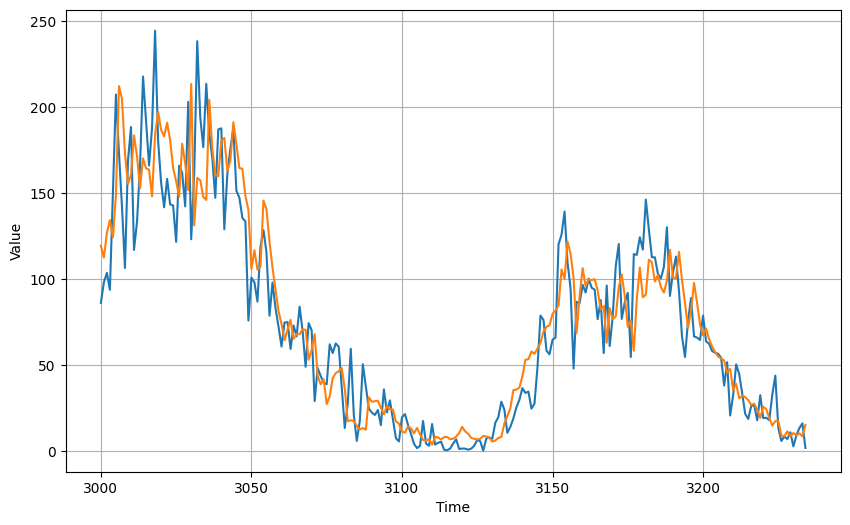

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [18]:
print(tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

547.3137
16.992073


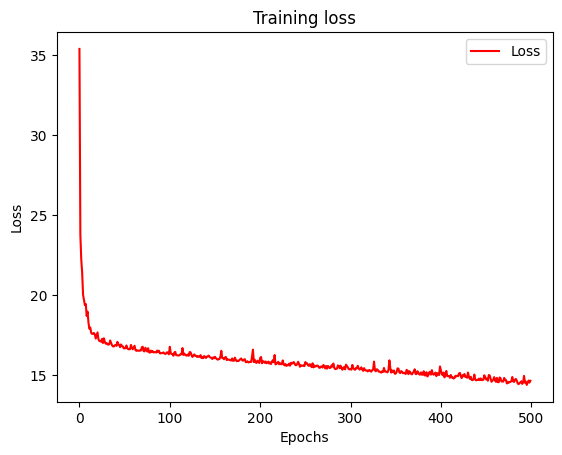

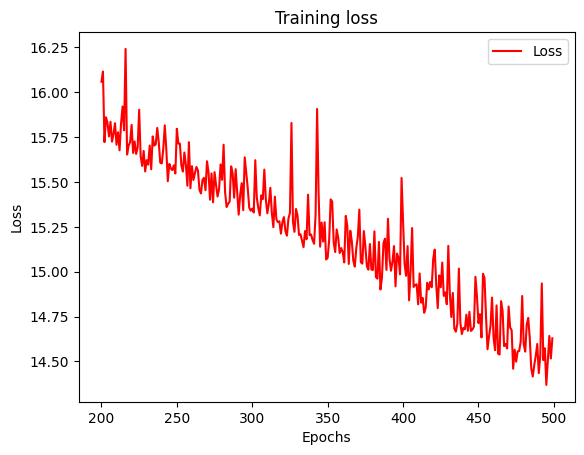

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()
plt.show()

In [20]:
print(rnn_forecast)

[119.3434    112.33686   126.77797   134.14122   124.09452   148.6264
 212.094     204.88345   172.72816   155.20375   160.42345   183.38834
 171.42664   152.65428   170.01956   164.27594   163.46701   147.93098
 183.87917   197.20221   186.71078   182.85744   190.8328    180.71423
 164.4416    156.71045   147.75818   178.59122   167.22835   151.63065
 213.29918   131.05597   158.66327   157.35085   147.74751   145.89084
 204.07903   176.01959   160.41156   159.72267   180.25287   181.94774
 162.86101   168.5249    191.06018   178.40901   164.45045   163.92778
 148.17862   140.0783    105.75471   116.63054   105.35933   107.10756
 145.53072   140.57948   121.57431   106.45       93.65394    81.188835
  73.7737     64.2472     70.46521    76.131424   65.13477    67.854355
  67.79067    70.71688    70.25085    52.901638   58.459187   67.84592
  43.65106    38.61601    41.572903   27.069607   31.648878   42.2946
  45.139416   46.291824   48.013405   36.12879    17.192677   17.738447
  17.